# Case 2: Collaborative Filtering via Deep Learning
-----

In this case, there are two main tasks:

- First, you need to build a deep learning model to predict the movie ratings.

- Then you will analyze the predicted ratings and provide an estimate of the movie valuation.

## Instructions

You need to fill in the missing code and submit the following files on Canvas
site:

1. A report in the pdf format containing the plots and the answers to the questions stated in the provided Jupyter notebook (Please read carefully the notebook and make sure answer every question);

2. The complete Jupyter notebook containing all your PyTorch code with explanations, along with
a Markdown text explaining different parts if needed.

---
## Introduction

One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



---
In this case, we'll build an explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content. We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

<img src='https://storage.googleapis.com/gweb-cloudblog-publish/images/f1-collab_filtering.max-900x900.png?raw=true' width=50% />

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

We start with importing the [Movielens 1M dataset](https://grouplens.org/datasets/movielens/1M/).  It contains 1,000,209 anonymous ratings of approximately 3,706 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

## Preparations

We first import the packages and download the data.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

In [ ]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

There are four different files:

- README
- movies.dat
- ratings.dat
- users.dat

You may read README to get the description of each dat files.

## Data analysis and formating

We start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

Note that the columns are separated by :: in the data.

In [ ]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


When showing the data, we would rather see movie titles than their IDs. The `movies.dat` contains the correspondence of IDs to movie titles.

In [ ]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the `all_ratings` data.

In [ ]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [ ]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975)


The dataframe `all_ratings` contains all the raw data for our problem.

In [ ]:
#number of entries
len(all_ratings)

1000209

In [ ]:
# statistics of ratings
all_ratings['ratings'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [ ]:
# The ratings are 1, 2, 3, 4, 5
all_ratings['ratings'].unique()

array([5, 4, 3, 2, 1])

We now check the user IDs.

In [ ]:
all_ratings['user_id'].describe()

count    1.000209e+06
mean     3.024512e+03
std      1.728413e+03
min      1.000000e+00
25%      1.506000e+03
50%      3.070000e+03
75%      4.476000e+03
max      6.040000e+03
Name: user_id, dtype: float64

In [ ]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that  the users seem to be indexed from 1 to 6040. Let's check that below using the following code.

In [ ]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [ ]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j)

We can see that `list_user_id` contains contiguous indices from 1 to 6040.

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [ ]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [ ]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16


We now look at movies.

In [ ]:
all_ratings['item_id'].describe()

count    1.000209e+06
mean     1.865540e+03
std      1.096041e+03
min      1.000000e+00
25%      1.030000e+03
50%      1.835000e+03
75%      2.770000e+03
max      3.952000e+03
Name: item_id, dtype: float64

In [ ]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [ ]:
itemnum_2_itemid = list(all_ratings['item_id'].unique())
itemnum_2_itemid.sort()
itemid_2_itemnum = {c:i for i,c in enumerate(itemnum_2_itemid)}
all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x: itemid_2_itemnum[x])

This function will verify that we have created `item_num` correctly.

In [ ]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [ ]:
check_ratings_num(all_ratings)

True

In [ ]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1,1104
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11,1104
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14,1104
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16,1104


### Preliminary data analysis

**Exercises**: Find the top 10 most popular movies in the dataset and include the result in your report

We sorted the dataset by **counting appearances of different movies**, the movies that got rated the most is considered as the most popular movie.



In [ ]:
# Find the top 10 most popular movies in the all_ratings dataset, count appearences based on item_num

popular_movies = all_ratings.groupby('item_name').size().sort_values(ascending=False)
top_10_movies = popular_movies.head(10)
top_10_movies

item_name
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
dtype: int64

**Exercise**: Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings). Include the plot in your report.

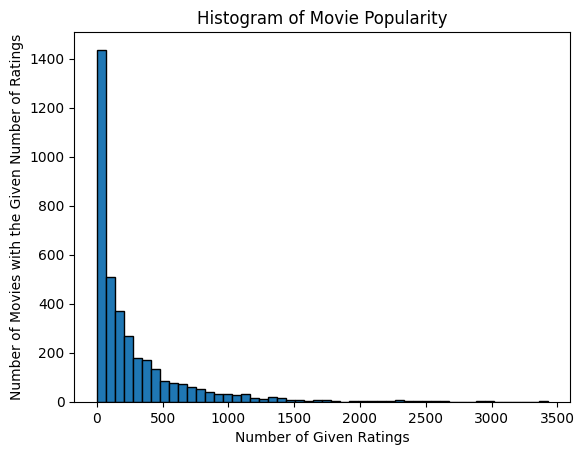

In [ ]:
import matplotlib.pyplot as plt
# Group the ratings DataFrame by item_id and count the number of ratings for each movie
movie_ratings_count = all_ratings.groupby('item_id').size()

# Plot the histogram
plt.hist(movie_ratings_count, bins=50, edgecolor='k')
plt.title('Histogram of Movie Popularity')
plt.xlabel('Number of Given Ratings')
plt.ylabel('Number of Movies with the Given Number of Ratings')
plt.show()


**Exercise**: Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings). Include the plot in your report.

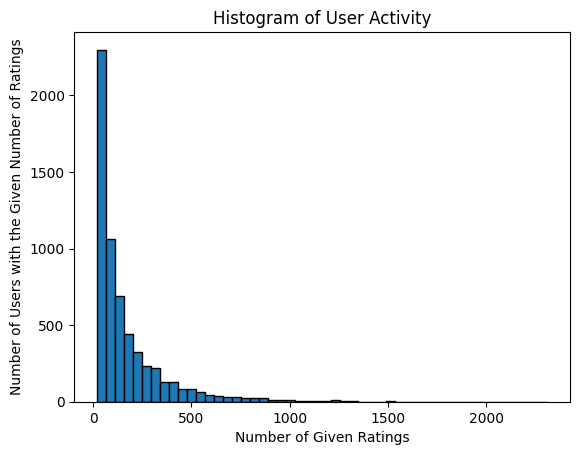

In [ ]:
user_ratings_count = all_ratings.groupby('user_id').size()

# Plot the histogram
plt.hist(user_ratings_count, bins=50, edgecolor='k')
plt.title('Histogram of User Activity')
plt.xlabel('Number of Given Ratings')
plt.ylabel('Number of Users with the Given Number of Ratings')
plt.show()

**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report. Are these highly rated movies popular?

Only 1 out of 20  in the `top20_rated` are also in the top 20 most popular movies. Most of the highly rated movies are not the most popular ones.

In [ ]:
# Compute the average ratings for each movie
average_ratings = all_ratings.groupby('item_name')['ratings'].mean().sort_values(ascending=False)

# Get the top 20 highly rated movies
top_20_highly_rated_movies = average_ratings.head(20)

# Check if these highly rated movies are also popular by finding their overall rating count
popularity_of_highly_rated_movies = all_ratings.groupby('item_name').size().loc[top_20_highly_rated_movies.index]

# Combine the average rating and popularity into a single DataFrame
top_20_movies_report = pd.DataFrame({
    'Average Rating': top_20_highly_rated_movies,
    'Number of Ratings': popularity_of_highly_rated_movies
}).reset_index()

top_20_movies_report

,item_name,Average Rating,Number of Ratings
0,Ulysses (Ulisse) (1954),5.000000,1
1,Lured (1947),5.000000,1
2,Follow the Bitch (1998),5.000000,1
3,Bittersweet Motel (2000),5.000000,1
4,Song of Freedom (1936),5.000000,1
5,One Little Indian (1973),5.000000,1
6,Smashing Time (1967),5.000000,2
7,Schlafes Bruder (Brother of Sleep) (1995),5.000000,1
8,"Gate of Heavenly Peace, The (1995)",5.000000,3
9,"Baby, The (1973)",5.000000,1


---
## Train, Validation, and Test Data

Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [ ]:
#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

In [ ]:
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [ ]:
movies_not_train = list(set(all_ratings['item_id']) -set(item_id_train))
movies_not_train_name=set(all_ratings.loc[movies_not_train]['item_name'])
print(movies_not_train_name)

{'My Fair Lady (1964)', 'James and the Giant Peach (1996)', "One Flew Over the Cuckoo's Nest (1975)", 'Erin Brockovich (2000)'}


In [ ]:
len(ratings_train['user_id'].unique())

6040

In [ ]:
len(ratings_train['item_id'].unique())

3676

We see that a few movies are not rated in the train set. For those movies, it is hard to predict their ratings accurately.

---
## Data Load and Batching

Use GPU if available.

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We define a function to return a triplet of user_num, item_num, rating from the dataframe.

In [ ]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [ ]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [ ]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list (Hint: you may use the [zip function](https://www.w3schools.com/python/ref_func_zip.asp)); then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling.

**Exercise**: Filling in the missing code below to construct dataset and dataloader.

In [ ]:
def tensor_2_dataset(user,item,rating):
    # your code here
    # Hint: check the zip function
    zip(user,item,rating)
    return torch.utils.data.TensorDataset(user,item,rating)

def make_dataloader(dataset,bs,shuffle):
    # your code here
    return torch.utils.data.DataLoader(dataset,bs,shuffle)


In [ ]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

Load the train, validation, and test data in batchs of size 1024.

In [ ]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

---
## The model



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will use some custom embeddings defined as below.

In [ ]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

### Creating Our Own Embedding Module

Now, we define the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.







**Exercise**: Fill the missing code to define the embeddings.

In [ ]:
class DotModel(nn.Module):

    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):

        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim

        # TODO: generate user and item embeddigns using ScaledEmbedding
        # your code
        self.user_embeddings = ScaledEmbedding(num_users,embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items,embedding_dim)

        # TODO: generate bias embeddigns using ZeroEmbedding
        # your code
        self.user_biases = ZeroEmbedding(num_users,1)
        self.item_biases = ZeroEmbedding(num_items,1)


    def forward(self, user_ids, item_ids):

        # TODO: compute and return the predicted rating based on the embedding vectors and biases.
        # your code
        #

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()
        return (self.user_embeddings(user_ids) * self.item_embeddings(item_ids)).sum(dim=1) + user_bias + item_bias

In [ ]:
net = DotModel(total_user_id,total_item_id).to(device)

In [ ]:
net

DotModel(
  (user_embeddings): ScaledEmbedding(6040, 32)
  (item_embeddings): ScaledEmbedding(3706, 32)
  (user_biases): ZeroEmbedding(6040, 1)
  (item_biases): ZeroEmbedding(3706, 1)
)

Now we check your network by taking  a batch from train loader.

In [ ]:
batch_user, batch_item, batch_rating = next(iter(train_dataloader))
batch_user, batch_item, batch_rating = batch_user.to(device), batch_item.to(device), batch_rating.to(device)

In [ ]:
batch_rating.shape,batch_user.shape,batch_item.shape

(torch.Size([1024]), torch.Size([1024]), torch.Size([1024]))

In [ ]:
predictions = net(batch_user, batch_item)
predictions.shape

torch.Size([1024])

We will use MSE loss defined below:

In [ ]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [ ]:
loss=regression_loss(predictions,batch_rating)

In [ ]:
loss

tensor(14.1416, device='cuda:0', grad_fn=<MeanBackward0>)

## Train and test the model

Now we define `FactorizationModel` class  that allows us to train and evaluate the explicit factorization models.


- The `fit` function should take as argument a dataloader for the training and a dataloader for the validation. At the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

- Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

**Exercise**: Filling in the missing code below to complete the training pass and validation pass.

In [ ]:
class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, dataloader, val_dataloader, verbose=True):
        if not self._initialized:
            self._initialize()

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_maes =[], [], [] # track train losses, valid loss, and valid maes over epoches

        for epoch_num in range(self._n_iter):
            tot_train_loss = 0.0
            ###################
            # train the model #
            ###################
            #TODO: trainining loop:
            # your code
            for batch_user, batch_item, batch_rating in dataloader:

                batch_user, batch_item, batch_rating = batch_user.to(self._device), batch_item.to(self._device), batch_rating.to(self._device)
                self._optimizer.zero_grad()

                predictions = self._net(batch_user, batch_item)
                loss = self._loss_func(predictions, batch_rating)
                loss.backward()
                self._optimizer.step()
                tot_train_loss += loss.item()

            train_loss = tot_train_loss /len(dataloader)

            # Go to the validation loop
            valid_loss, valid_mae = self.test(val_dataloader)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_maes.append(valid_mae)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, train_loss,valid_loss))

            if np.isnan(train_loss) or train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(train_loss))

            #TODO: Saving model if validation loss has decreased
            # your code
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(self._net.state_dict(), 'model_cf.pt')
                valid_loss_min = valid_loss

        return train_losses, valid_losses, valid_maes

    ######################
    # validate/Test the model #
    ######################
    def test(self,dataloader, verbose = False):
        self._net.eval()
        L1loss = torch.nn.L1Loss()
        L2loss = torch.nn.MSELoss()
        tot_test_loss = 0.0
        tot_test_mae = 0.0
        total_samples = 0

        for batch_user, batch_item, batch_rating in dataloader:
          batch_user, batch_item, batch_rating = batch_user.to(self._device), batch_item.to(self._device), batch_rating.to(self._device)
          with torch.no_grad():
            predictions = self._net(batch_user, batch_item)
            L1_loss = L1loss(predictions, batch_rating)
            L2_loss = L2loss(predictions, batch_rating)

            tot_test_loss += L2_loss.item()
            tot_test_mae += L1_loss.item()

        test_loss = tot_test_loss / len(dataloader)
        test_mae = tot_test_mae / len(dataloader)
        if verbose:
          print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return test_loss, test_mae

In [ ]:
#TODO: Construct your model using FactorizationModel
model = FactorizationModel(num_users=6040,num_items=3706,embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2)

**Exercise**: Train the model and plot the train losses and valid losses over epoches.
At which epoch, you would stop the training? Include the plot and your answer in the report.

We should stop at the second epoch since validation losses does not decrease any more.

Epoch 0: loss_train 2.1150723858313127, loss_val 0.8771106756546281
Validation loss decreased (inf --> 0.877111).  Saving model ...
Epoch 1: loss_train 0.7939812717865212, loss_val 0.8758264881643382
Validation loss decreased (0.877111 --> 0.875826).  Saving model ...
Epoch 2: loss_train 0.7092305437633486, loss_val 0.8830347623337399
Epoch 3: loss_train 0.6563538035961113, loss_val 0.904751606285572
Epoch 4: loss_train 0.6262508014386351, loss_val 0.923379199071364
Epoch 5: loss_train 0.6066776234468426, loss_val 0.936421659859744
Epoch 6: loss_train 0.594533668586401, loss_val 0.9541185389865529
Epoch 7: loss_train 0.5847071697088805, loss_val 0.9581521417606961
Epoch 8: loss_train 0.5767531592135478, loss_val 0.9629275236617435
Epoch 9: loss_train 0.5708051262931391, loss_val 0.9735839549790729


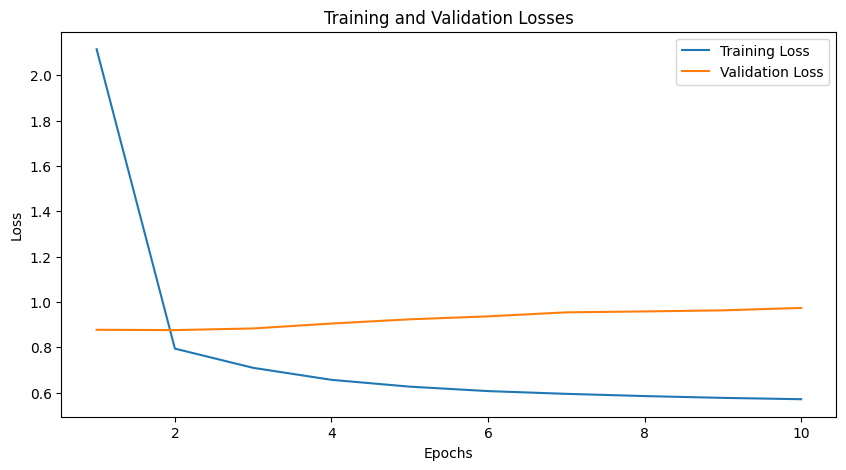

In [ ]:
import matplotlib.pyplot as plt
train_losses, valid_losses, valid_maes = model.fit(train_dataloader, val_dataloader)

# Plotting
epochs = range(1, model._n_iter + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Exercise**: Now, let's compute the RMSE and mean absolute error on the test data. Include your answers in your report.

We already know that the model is optimized when number of epochs = 2. Thus we initialized another model `model_optimized` with optimized parameters to compute MAE and RMSE on test data

Our best model has **RMSE: 0.9420028457807293, MAE: 0.7396797416161518**

In [ ]:
model_optimized=FactorizationModel(num_users=6040,num_items=3706,embedding_dim=32, n_iter=2, l2=0.0,
                 learning_rate=1e-2)

In [ ]:
model_optimized.fit(train_dataloader, val_dataloader)

Epoch 0: loss_train 2.1058592708273367, loss_val 0.8909742825410583
Validation loss decreased (inf --> 0.890974).  Saving model ...
Epoch 1: loss_train 0.8053331524886266, loss_val 0.8679887462746013
Validation loss decreased (0.890974 --> 0.867989).  Saving model ...


([2.1058592708273367, 0.8053331524886266],
 [0.8909742825410583, 0.8679887462746013],
 [0.7434129003774036, 0.7336114137010141])

In [ ]:
model_optimized.test(test_dataloader,verbose=True)

RMSE: 0.9307561681320218, MAE: 0.7323616998536246


(0.8663070445158043, 0.7323616998536246)

## Optimize your model and training

**Exercise**: Play with the hyperparameters (embedding_dim, n_iter, learning_rate, L2 regularization, etc) to beat the benchmarks presented in [Surprise](https://github.com/NicolasHug/Surprise). List the hyperparameters and the RMSE and MAE on test data in the report. Save the model state to `model_cf.pt` and submit it to Canvas.


Here is comparison between the best benckmarks in [Surprise](https://github.com/NicolasHug/Surprise) and your model after hyperparameters tunning.

| [Movielens 1M](https://grouplens.org/datasets/movielens/1m)                                                                             |   RMSE |   MAE |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [SVD++ (cache_ratings=False)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| [SVD++ (cache_ratings=True)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| **Yours**|  **0.9420028457807293** | **0.7396797416161518** |



## Interpreting Biases

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

**Exercise**: What are your top 10 movies with the largest values of movie bias? What do you think about this ranking? Include your answers in your report.

Higher bias values indicate that the movie is more positively rated or preferred by users in the system. This ranking suggests that, according to the recommender system's bias values, "Star Wars: Episode IV - A New Hope" is the most favored movie among users, followed by "The Shawshank Redemption" and others. This is not surprising given that these are all traditionally considered as good movies.

In [ ]:
#TODO: retreive the bias of the movies from your optimized model and store it in the numpy array item_bais_np
item_bias_np = model._net.item_biases.weight.detach().cpu().numpy()
item_bias_np = item_bias_np.squeeze()

In [ ]:
# construct a dictionary that maps item_num to item_name, and vice versa
numitem_2_name = {i:name for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}
name_2_numitem = {name:i for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}

In [ ]:
# Construct a list of movie names and the corresponding bias.
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['item_name'].unique())]

In [ ]:
#TODO: sort the movie names by biases and output the top 10 movie names with the largest biases.

#sort
list_name_bias.sort(key=lambda x: x[1], reverse=True)
# Select the top 10 movies
top_10_movies = list_name_bias[:10]
# Print
for movie in top_10_movies:
    print("Movie Name:", movie[0], "Bias:", movie[1])

Movie Name: Star Wars: Episode IV - A New Hope (1977) Bias: 2.8963723
Movie Name: Raiders of the Lost Ark (1981) Bias: 2.8858511
Movie Name: Godfather, The (1972) Bias: 2.8098865
Movie Name: Star Wars: Episode V - The Empire Strikes Back (1980) Bias: 2.6839035
Movie Name: Shawshank Redemption, The (1994) Bias: 2.674207
Movie Name: Schindler's List (1993) Bias: 2.6664867
Movie Name: Usual Suspects, The (1995) Bias: 2.6563222
Movie Name: Silence of the Lambs, The (1991) Bias: 2.6194866
Movie Name: Matrix, The (1999) Bias: 2.5946424
Movie Name: Sixth Sense, The (1999) Bias: 2.5688622


## PCA of movies' embeddings

Now you can also play with the embeddings learned by your algorithm for the movies.

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this class, because it is not particularly important for you to understand to be a deep learning practitioner. We can visualize the movie embeddings based on two of the strongest PCA components.

**Exercise**: Do you observe anything interesting from the movie embeddings? Include the plot of the movie embeddings and your answer in your report.

Movies that are close to each other in the embedding space may share similar features or attributes. This could be due to similar genres, themes, or audience preferences. For example, "Star Wars", "Total Recall", and "Twelve Monkeys" movies are close to each other, it may indicate that the model has learned that science fiction fans like them.

In [ ]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [ ]:
#TODO: retrive your movie embedding vectors and store them as a numpy matrix
item_emb_np = model._net.item_embeddings.weight.detach().cpu().numpy()
item_emb_np = item_emb_np.squeeze()

In [ ]:
#Here we perform PCA to extract the 4 principal components
pca = PCA(n_components=4)
latent_fac = pca.fit_transform(item_emb_np)

Next, we plot the embeddings of the top 80 mostly rated movies using the second and third principal components.

In [ ]:
#Here we get the top 1000 mostly rated movies
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
# we get the corresponding movie numbers
most_rated_movies_num = [name_2_numitem[n] for n in most_rated_movies]

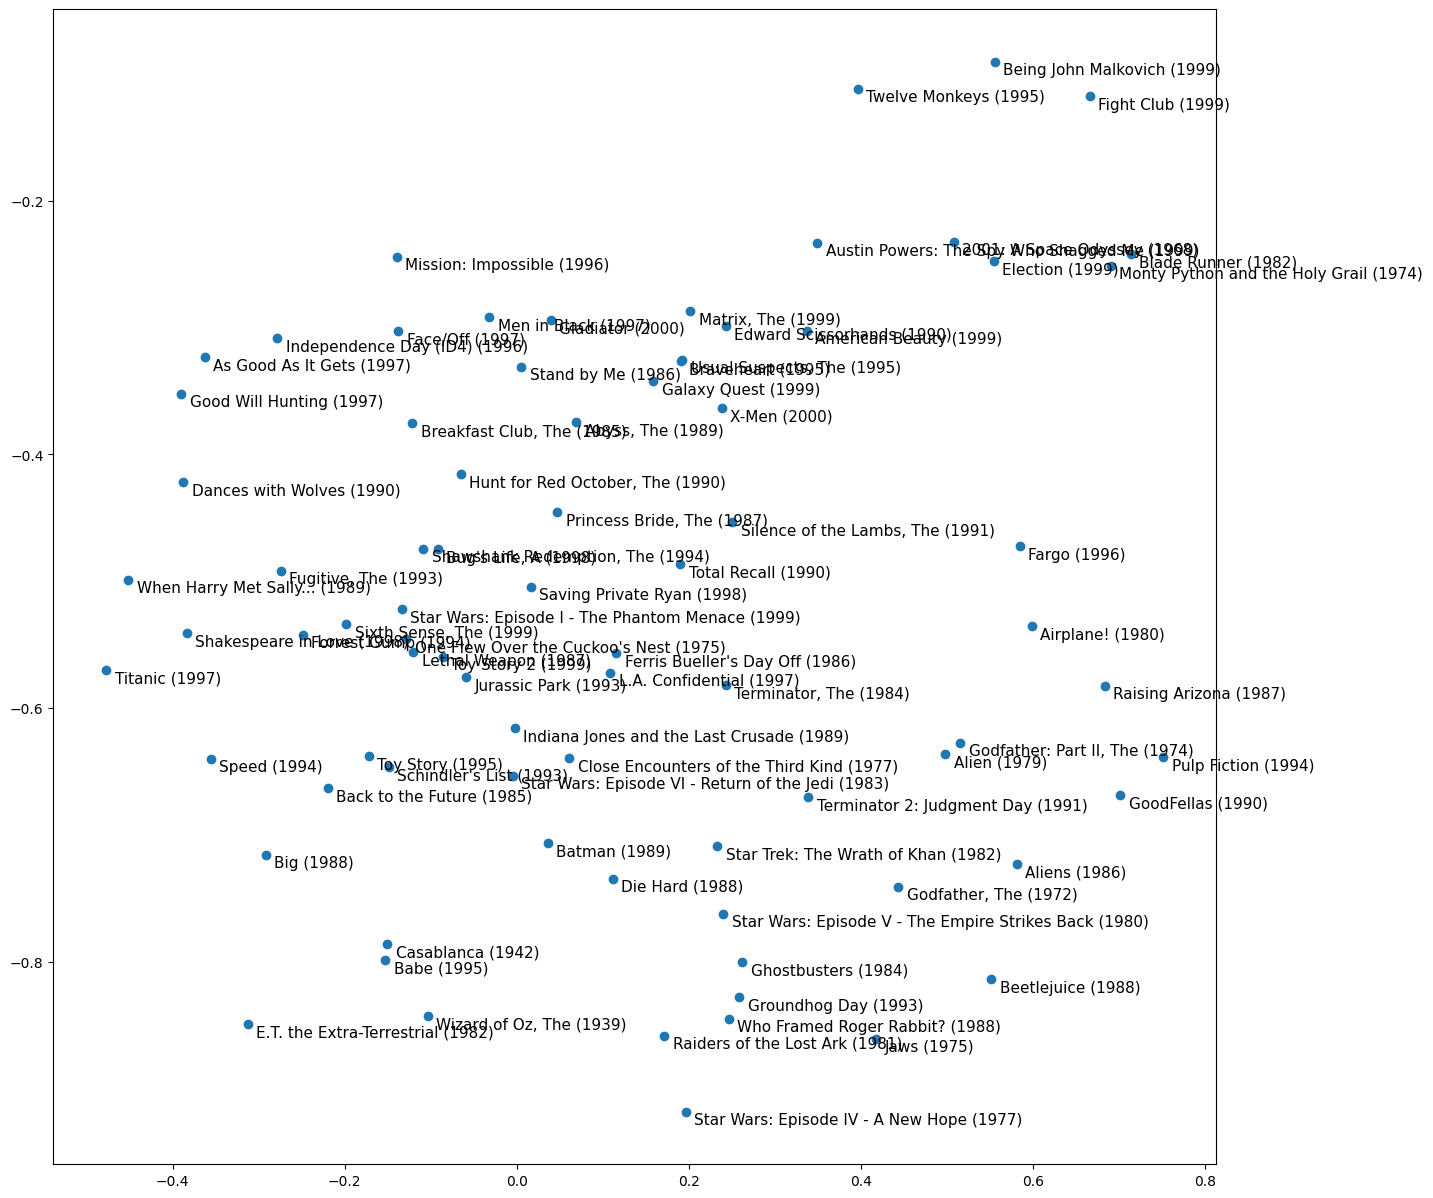

In [ ]:
nums = most_rated_movies_num[:80]
txt_movies_names = [numitem_2_name[i] for i in nums]
X = latent_fac[nums,1]
Y = latent_fac[nums,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

## Predict your own ratings

Now that we have succesfully trained a model, let's see how to deal with the situation where we have a new user. How can we make recommendations to new users?

It turns out that we can utilize the learned movie embedding vectors to estimate new users' embedding vector, based on a few ratings from them. You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what movie or music you like; this is how they come up with your initial collaborative filtering recommendations.


- First, give 40 ratings between 1-5 to the movies that your team watched before among the mostly rated movies;

In [ ]:
user_id = 9999

movie_40 = [
    3428, 2991, 2990, 2883, 2672, 2653, 2649, 2590, 2583, 2578,
    2538, 2514, 2513, 2459, 2443, 2369, 2304, 2288, 2278, 2269,
    1996, 2024, 2077, 2098, 2227, 1585, 1692, 1718, 1448, 1511,
    1310, 1297, 1900, 1727, 957, 1439, 2898, 574, 1148, 1176
]
ratings_40 = [5] * 40

# Create a list of dictionaries, each representing a single rating
ratings_list = [{'user_num': user_id, 'item_num': movie_id, 'ratings': rating}
                for movie_id, rating in zip(movie_40, ratings_40)]

# Convert the list to a DataFrame
my_ratings = pd.DataFrame(ratings_list)


In [ ]:
my_ratings

,user_num,item_num,ratings
0,9999,3428,5
1,9999,2991,5
2,9999,2990,5
3,9999,2883,5
4,9999,2672,5
5,9999,2653,5
6,9999,2649,5
7,9999,2590,5
8,9999,2583,5
9,9999,2578,5



- Second, compute your own embedding vector `my_emb_np` and `my_emb_bias` by running an ordinary least squares with L_2 regularization based on your ratings and the previously computed movie embedding vectors. In other words, `item_emb_np` is the co-variate and your own 40 ratings are the response.

  Hint: you may use the [ridge regression (linear regression with L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) in the sklearn package.

In [ ]:
#TODO: compute your own embedding vector and bias

from sklearn.linear_model import Ridge
import numpy as np

# Extract the relevant movie embeddings
# Assuming item_emb_np is a matrix where each row corresponds to a movie's embedding
movie_indices = my_ratings['item_num']  # Get the indices of the movies you've rated
X = item_emb_np[movie_indices]  # Extract the corresponding embeddings

# Your ratings are the response variable
y = my_ratings['ratings']

# Perform Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

# Your embedding vector is the coefficient of the regression model
my_emb_np = ridge_model.coef_

# The bias is the intercept of the model
my_emb_bias = ridge_model.intercept_


-  Then compute the predicted ratings for all movies using your embedding vectors and biases, together with the movie embedding vectors and biases.

In [ ]:
# compute pred_ratings
pred_ratings = np.matmul(item_emb_np, my_emb_np.T) + item_bias_np + my_emb_bias

- Finally, among all movies that you haven't rated, output the top 10 movies with the highest predicted ratings.

In [ ]:
# output the top 10 movies with the highest predicted ratings.

# Create a dictionary mapping from indices to names
index_to_movie_name = pd.Series(all_ratings.item_name.values, index=all_ratings.item_num).to_dict()

all_movie_indices = np.arange(len(pred_ratings))

# Indices of movies we've rated
rated_movie_indices = my_ratings['item_num'].values

# Find indices of movies we haven't rated
unrated_movie_indices = np.setdiff1d(all_movie_indices, rated_movie_indices)

# Get predicted ratings for movies we haven't rated
unrated_movie_ratings = pred_ratings[unrated_movie_indices]

# Pair each unrated movie with its predicted rating
unrated_movie_pairs = list(zip(unrated_movie_indices, unrated_movie_ratings))

# Sort the list by ratings in descending order and select the top 10
top_10_unrated_movies = sorted(unrated_movie_pairs, key=lambda x: x[1], reverse=True)[:10]

# Output the top 10 movies with names
print("Top 10 Unrated Movies with Highest Predicted Ratings:")
for movie_index, rating in top_10_unrated_movies:
    movie_name = index_to_movie_name[movie_index]  # Get the movie name from the index
    print(f"Movie Name: {movie_name}, Movie Index: {movie_index},Predicted Rating: {rating}")

Top 10 Unrated Movies with Highest Predicted Ratings:
Movie Name: Star Wars: Episode IV - A New Hope (1977), Movie Index: 253,Predicted Rating: 7.896372318267822
Movie Name: Raiders of the Lost Ark (1981), Movie Index: 1108,Predicted Rating: 7.88585090637207
Movie Name: Godfather, The (1972), Movie Index: 802,Predicted Rating: 7.809886455535889
Movie Name: Star Wars: Episode V - The Empire Strikes Back (1980), Movie Index: 1106,Predicted Rating: 7.683903694152832
Movie Name: Shawshank Redemption, The (1994), Movie Index: 309,Predicted Rating: 7.674206733703613
Movie Name: Schindler's List (1993), Movie Index: 513,Predicted Rating: 7.666486740112305
Movie Name: Usual Suspects, The (1995), Movie Index: 49,Predicted Rating: 7.656322479248047
Movie Name: Silence of the Lambs, The (1991), Movie Index: 579,Predicted Rating: 7.6194868087768555
Movie Name: Matrix, The (1999), Movie Index: 2374,Predicted Rating: 7.594642639160156
Movie Name: Sixth Sense, The (1999), Movie Index: 2557,Predicted 

**Question**: How do you feel about the predicted ratings? Do you like these top 10 movies? Include your answer in your report.

---
## Movie valuation

The rating data provided the company like Netflix information about the value of a movie that was not available to movie production studios. The collaborative filting algorithm allows Netflix to accurately value the content in a data-driven manner. For example, if Netflix were offered the opportunity to license *Toy Story (1995)*, it would need to provide Disney an initial quote of the license fee. Traditional methods suggest looking at box office returns of *Toy Story* franchise and projecting the potential value of the film.

In this following, we will explore a novel approach to determine the valuation of a movie based on the predicted ratings. We make the following simplifying assumpitons (Note that these assumptions can be certainly relaxed with more complicated procedures and data):

- **Netflix are focusing on the top 1000 active users and 1000 popular movies (with the most number of observed ratings).** In other words, in the following movie valuation calculation, we just consider the top 1000 activie users and 1000 popular movies, disregarding the rest.

- For each user, the total amount of viewing time is proportional to the number of observed ratings. In other words, more active users spend more time on Netflix;

- For each given user, the viewing time across different movies follow a [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), that is

  $$
    \text{Viewtime of movie $i$} \propto \frac{1}{\text{rank of } i }
  $$
  Here the rank of $i$ is determined by sorting the **predicted rating** of movie $i$ by the user in descending order. In other words, the user spend less time on watching movies with lower ratings.

- Netflix has a fixed total budget of 1 Billion dollars to license the content;

- Netflix estimates the value of a movie based on the expected share of customer viewing time of the movie on its platform:
$$
\text{Value of a movie $i$ } = \frac{\text{View time of movie $i$ of all users}}{\text{Total view time of all users} } \times \text{Total content license budget}
$$


### Compute the value of each movie

In [ ]:
# Get indices for top 1000 active users and top 1000 mostly rated movies
top1000_user_num = pd.Series(all_ratings["user_num"].value_counts()[:1000].index, name="user_num")
top1000_item_num = pd.Series(all_ratings["item_num"].value_counts()[:1000].index, name="item_num")
# Construct dataframes for storing predicted ratings
pred_ratings = pd.merge(top1000_user_num, top1000_item_num, how="cross")
cartesian_user_num = torch.from_numpy(np.asarray(pred_ratings["user_num"])).to(device)
cartesian_item_num = torch.from_numpy(np.asarray(pred_ratings["item_num"])).to(device)

In [ ]:
pred_ratings.head()

,user_num,item_num
0,4168,2651
1,4168,253
2,4168,1106
3,4168,1120
4,4168,466


In [ ]:
# sanity check: # of rows in pred_ratings == # of active users (1000) x # of popular items (1000)
pred_ratings.shape[0] == 1000 * 1000

True

In [ ]:
#TODO: use your optimized model to compute the predicted ratings among the top 1000 active users and top 1000 popular movies
pred_ratings["pred_ratings"] = model._net(cartesian_user_num, cartesian_item_num).detach().cpu().numpy()


In [ ]:
# Each user's total viewtime is stored in Series user_total_viewtime
user_total_viewtime = all_ratings["user_num"].value_counts()[:1000] / all_ratings["user_num"].value_counts()[:1000].sum()
user_total_viewtime.name = "user_total_viewtime"
user_total_viewtime.index.name = "user_num"
pred_ratings = pd.merge(pred_ratings, user_total_viewtime, left_on="user_num", right_on="user_num", how="left")


In [ ]:
pred_ratings.head()

,user_num,item_num,pred_ratings,user_total_viewtime
0,4168,2651,5.119305,0.00449
1,4168,253,4.974538,0.00449
2,4168,1106,4.954963,0.00449
3,4168,1120,4.303752,0.00449
4,4168,466,4.076423,0.00449


In [ ]:
# Each user per each movie viewtime: pred_all_ratings["user_item_viewtime"] = ["1/user_rank"] / ["sum(1/user_rank)"] * ["user_total_viewtime"]
# these wordy codes are to reduce RAM consumption otherwise Colab may crush
pred_ratings["1/user_rank"] = 1/pred_ratings.groupby("user_num")["pred_ratings"].rank(method = "min", ascending = False)
sum_inverse_user_rank = pred_ratings.groupby("user_num")["1/user_rank"].sum()
sum_inverse_user_rank.name = "sum(1/user_rank)"
pred_ratings = pd.merge(pred_ratings, sum_inverse_user_rank, left_on="user_num", right_on="user_num", how="left")
pred_ratings["user_item_viewtime"] = pred_ratings["1/user_rank"] / pred_ratings["sum(1/user_rank)"] * pred_ratings["user_total_viewtime"]

In [ ]:
pred_ratings

,user_num,item_num,pred_ratings,user_total_viewtime,1/user_rank,sum(1/user_rank),user_item_viewtime
0,4168,2651,5.119305,0.004490,0.047619,7.485471,2.856540e-05
1,4168,253,4.974538,0.004490,0.025641,7.485471,1.538137e-05
2,4168,1106,4.954963,0.004490,0.024390,7.485471,1.463106e-05
3,4168,1120,4.303752,0.004490,0.003788,7.485471,2.272248e-06
4,4168,466,4.076423,0.004490,0.002778,7.485471,1.666315e-06
...,...,...,...,...,...,...,...
999995,3411,2126,3.405137,0.000569,0.001138,7.485471,8.641220e-08
999996,3411,67,4.836586,0.000569,0.006757,7.485471,5.132184e-07
999997,3411,2614,4.236758,0.000569,0.002101,7.485471,1.595721e-07
999998,3411,1608,3.688226,0.000569,0.001276,7.485471,9.688306e-08


In [ ]:
# sanity check: sum of user_item_viewtime == 1
pred_ratings["user_item_viewtime"].sum()

1.0

In [ ]:
# compute each movie's value
budget =  1000000000
#TODO: compute and store the values of movies based on pred_ratings

# Sum the viewtime for each movie across all users
total_movie_viewtime = pred_ratings.groupby("item_num")["user_item_viewtime"].sum()

# Calculate each movie's value
total_viewtime = total_movie_viewtime.sum()
movie_values = (total_movie_viewtime / total_viewtime) * budget
# Convert the result to a DataFrame and set the name for the value column
movie_values = movie_values.reset_index()
movie_values.columns = ["item_num", "item_value"]

In [ ]:
movie_values.head()

,item_num,item_value
0,0,1.073990e+06
1,1,1.914445e+05
2,2,3.659069e+05
3,5,5.414728e+05
4,6,2.995148e+05


In [ ]:
# replace item_num by item_name
movie_values["item_name"] = [numitem_2_name[item_num] for item_num in movie_values.index]
movie_values = movie_values.set_index("item_name").squeeze(axis=1)

In [ ]:
movie_values.head()

,item_num,item_value
item_name,,
Toy Story (1995),0,1.073990e+06
Jumanji (1995),1,1.914445e+05
Grumpier Old Men (1995),2,3.659069e+05
Waiting to Exhale (1995),5,5.414728e+05
Father of the Bride Part II (1995),6,2.995148e+05


In [ ]:
# sanity check: sum of movie values == budget
movie_values.sum() == budget

item_num      False
item_value    False
dtype: bool

In [ ]:
movie_values['item_value'].sum()

1000000000.0000001

### Output the top valued movies

**Question**: Include your answer in the report.

- What is your estimated value of *Toy Story (1995)*?

- What are the top 10 mostly valued movies?


 Estimated value of Toy Story (1995) is 1.073990e+06;
 Top 10 mostly valued movies are listed below:

In [ ]:
# Sort the movie_values by 'item_value' in descending order
sorted_movie_values = movie_values.sort_values(by='item_value', ascending=False)
# Top 10 mostly valued movies
sorted_movie_values.head(10)

,item_num,item_value
item_name,,
Pulp Fiction (1994),1108,1.505670e+07
Destiny Turns on the Radio (1995),892,1.406484e+07
Strange Days (1995),802,1.372315e+07
Fair Game (1995),253,1.276045e+07
Nell (1994),1066,1.223433e+07
Walking and Talking (1996),2651,1.094664e+07
Last Summer in the Hamptons (1995),309,9.853396e+06
Dead Man (1995),2374,9.323660e+06
Die Hard: With a Vengeance (1995),593,8.863460e+06


In [ ]:
# find the rows where item_name = 'Toy Story (1995)'

sorted_movie_values.loc[sorted_movie_values.index == 'Toy Story (1995)']


,item_num,item_value
item_name,,
Toy Story (1995),0,1.073990e+06



### Compare the output with the mostly rated movies. Identify the discrepancies.

**Question**: Include your answers in your report.

- What are the movies that are top 30 rated but not in top 30 valued?
- What do you think about this approach of movie valuation? How does it compare with the approach based on the popularity of the movies?




`Sixth Sense, The (1999)`,
 `Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)`,`Double Indemnity (1944)` are top 30 rated but not in top 30 valued

In [ ]:
# Calculate the mean predicted rating for each movie
mean_pred_ratings = pred_ratings.groupby("item_num")["pred_ratings"].mean()

# Sort by the mean predicted ratings in descending order and get the top 30 rated movies
top30_rated = mean_pred_ratings.sort_values(ascending=False).head(30)

# Extract the item numbers of the top 30 valued movies
top30_valued_item_nums = set(sorted_movie_values.head(30)['item_num'])

# Convert top30_rated Series to a df for easier processing
top30_rated_df = top30_rated.reset_index()
top30_rated_df.columns = ['item_num', 'mean_pred_rating']

# Find the movies that are in top30_rated but not in top30_valued
top_rated_not_valued = top30_rated_df[~top30_rated_df['item_num'].isin(top30_valued_item_nums)]

In [ ]:
# print movies that are in top30_rated but not in top30_valued
print(top_rated_not_valued)

    item_num  mean_pred_rating
22      2557          4.334657
27      3203          4.321239
28      1839          4.315223


In [ ]:
# movies names that are in top30_rated but not in top30_valued

movie_names = all_ratings[all_ratings["item_num"].isin([2557, 3203, 1839])]
print(movie_names['item_name'].unique())


['Sixth Sense, The (1999)'
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Double Indemnity (1944)']
